In [270]:
import pandas as pd
import USA_oil_data as oil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

# monthly SD

In [271]:
weekly_stocks = oil.weekly_stocks().to_frame() / 7
weekly_stocks['change'] = weekly_stocks['stocks'].diff(-1)
weekly_stocks['SD_change'] = weekly_stocks['change'].diff(-52)

weekly_stocks['year'] = weekly_stocks.index.year
weekly_stocks['month'] = weekly_stocks.index.month
week_info = weekly_stocks.index.isocalendar()
week_number = week_info['week']
weekly_stocks = pd.merge(week_number, weekly_stocks, left_index=True, right_index=True)

weekly_stocks = weekly_stocks[weekly_stocks['week'] <= 52]
weekly_stocks = weekly_stocks[weekly_stocks['year'] >= 2018]

grouped = weekly_stocks.groupby('year')

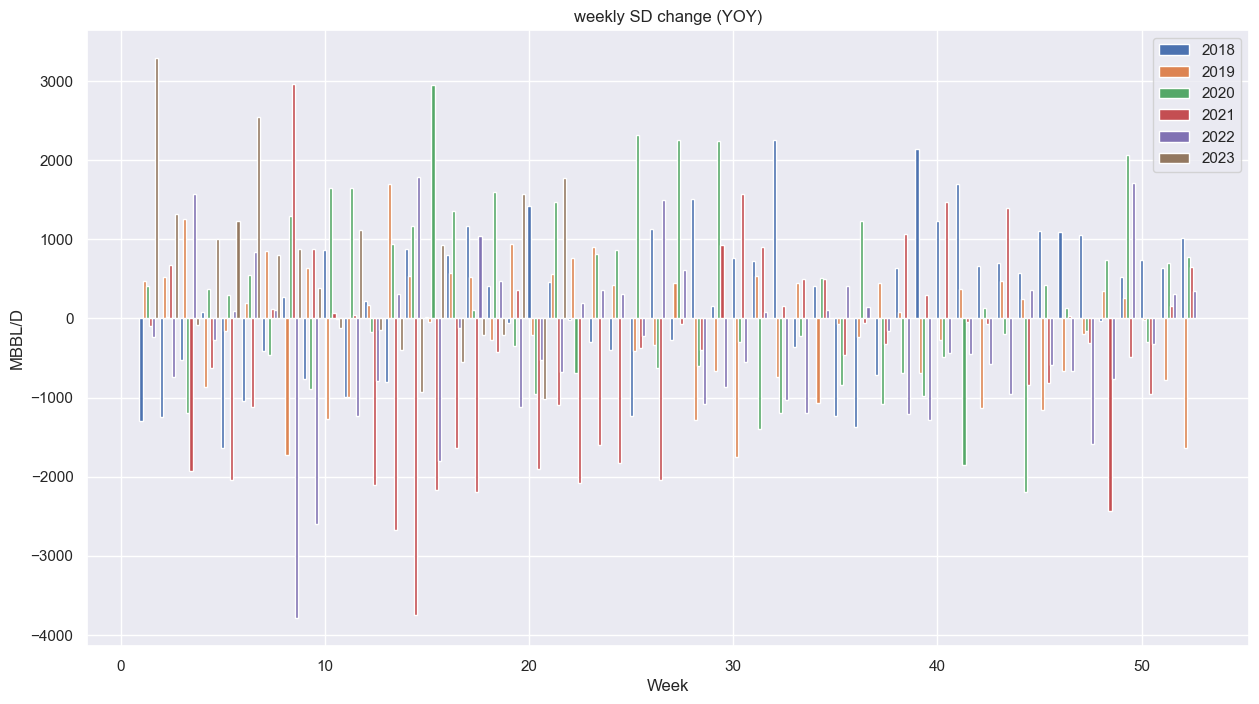

In [272]:
pos = 0
width = 0.15
fig, ax = plt.subplots(figsize=(15,8))
for name, group in grouped:
    position = group['week']
    data = group['SD_change']
    data = data[:52]
    ax.bar(position + pos * width, data, width=width, label=name)
    pos += 1
plt.legend()
plt.xlabel('Week')
plt.ylabel('MBBL/D')
plt.title('weekly SD change (YOY)')
plt.show()

In [273]:
monthly_SD_data = []
for name, group in grouped:
    year = name
    monthly_group = group.groupby('month')
    for n, g in monthly_group:
        week = n
        data = g['SD_change'].sum()
        monthly_SD_data.append([year, week, data])

monthly_SD_df = pd.DataFrame(monthly_SD_data, columns=['year', 'month', 'SD_change'])

grouped = monthly_SD_df.groupby('year')

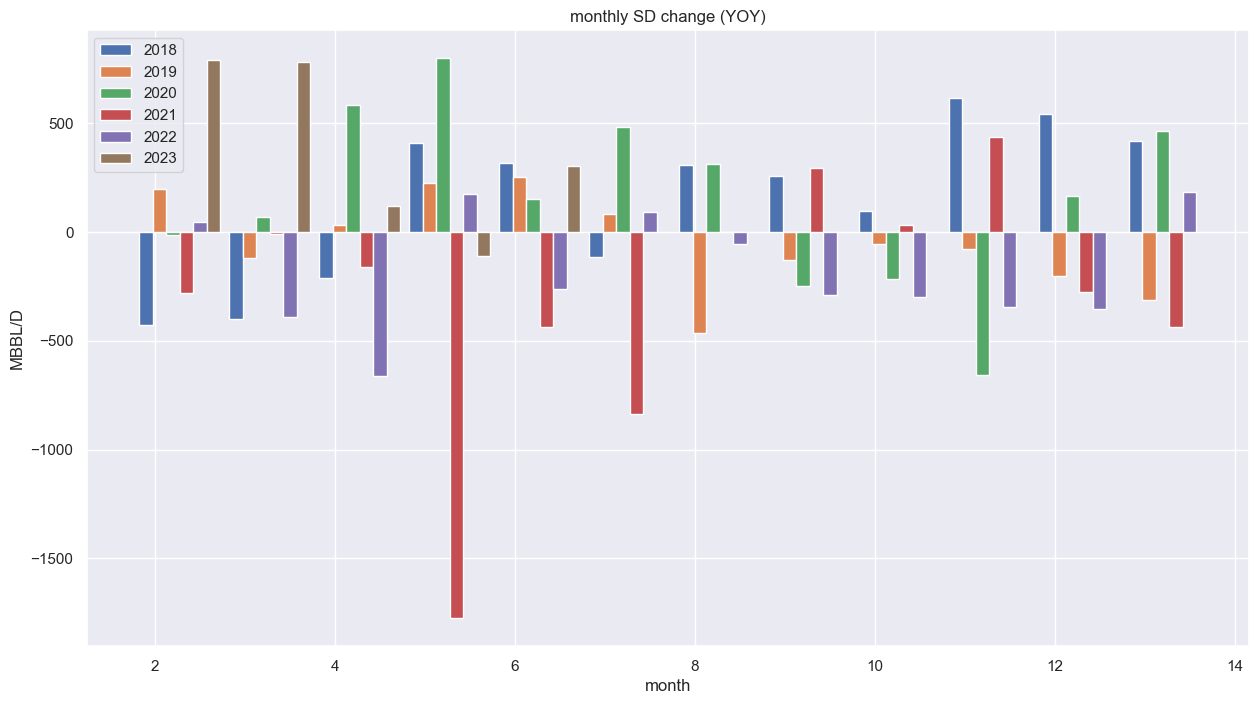

In [274]:
os = 0
width = 0.15
fig, ax = plt.subplots(figsize=(15,8))
for name, group in grouped:
    position = group['month']
    data = group['SD_change'] / 7
    ax.bar(position + pos * width, data, width=width, label=name)
    pos += 1

plt.legend()
plt.xlabel('month')
plt.ylabel('MBBL/D')
plt.title('monthly SD change (YOY)')
plt.show()

In [275]:
monthly_SD_df['date'] = pd.to_datetime(monthly_SD_df['year'].astype(str) + '-' + monthly_SD_df['month'].astype(str) + '-1')

In [276]:
monthly_SD_df.set_index('date', inplace=True)

In [277]:
display(monthly_SD_df)

,year,month,SD_change
date,,,
2018-01-01,2018,1,-2987.571429
2018-02-01,2018,2,-2812.142857
2018-03-01,2018,3,-1487.000000
2018-04-01,2018,4,2857.285714
2018-05-01,2018,5,2226.285714
...,...,...,...
2023-01-01,2023,1,5531.285714
2023-02-01,2023,2,5447.000000
2023-03-01,2023,3,833.571429


In [278]:
#net imports
imports, exports = oil.imports_exports(only_crude=False)
imports_exports = pd.merge(imports, exports, on='period')
imports_exports['year'] = imports_exports.index.year
imports_exports = imports_exports[imports_exports['year'] > 2005]
net_imports = imports_exports['imports'] - imports_exports['exports']
net_imports.rename("net_imports", inplace=True)
net_imports = net_imports.groupby(pd.Grouper(freq='MS')).mean()

#production
production = oil.mbbl_production(daily=True)

#product supplied (EIA uses product supplied to represent U.S. petroleum consumption)
product_supplied = oil.monthly_product_supplied()
product_supplied = product_supplied * -1

#refinery/blender net inputs
net_refinery = oil.refinery_net_input(daily=True)

supply_demand = pd.merge(production, product_supplied, on='period')
supply_demand = pd.merge(supply_demand, net_imports, on='period')
#supply_demand = pd.merge(supply_demand, net_refinery, on='period')

changes = supply_demand.diff(1)
changes = supply_demand.diff(12)

sd = monthly_SD_df['SD_change'].rename('SD')



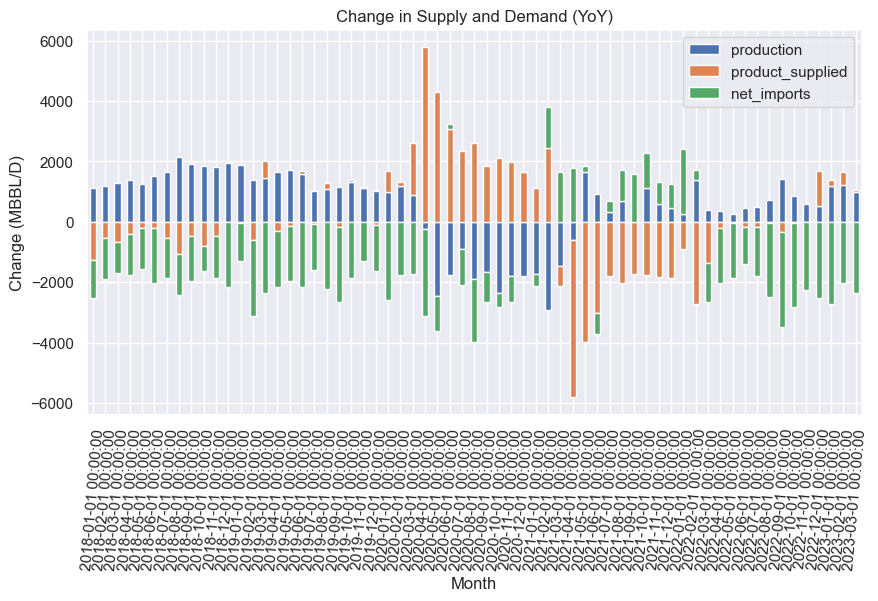

In [279]:
changes = changes[changes.index > '2017-12-01']
fig, ax = plt.subplots(figsize=(10,5))
changes.plot(kind='bar', stacked=True, ax=ax)
plt.title('Change in Supply and Demand (YoY)')
ax.set_xlabel('Month')
ax.set_ylabel('Change (MBBL/D)')
plt.xticks(rotation=85)
plt.show()

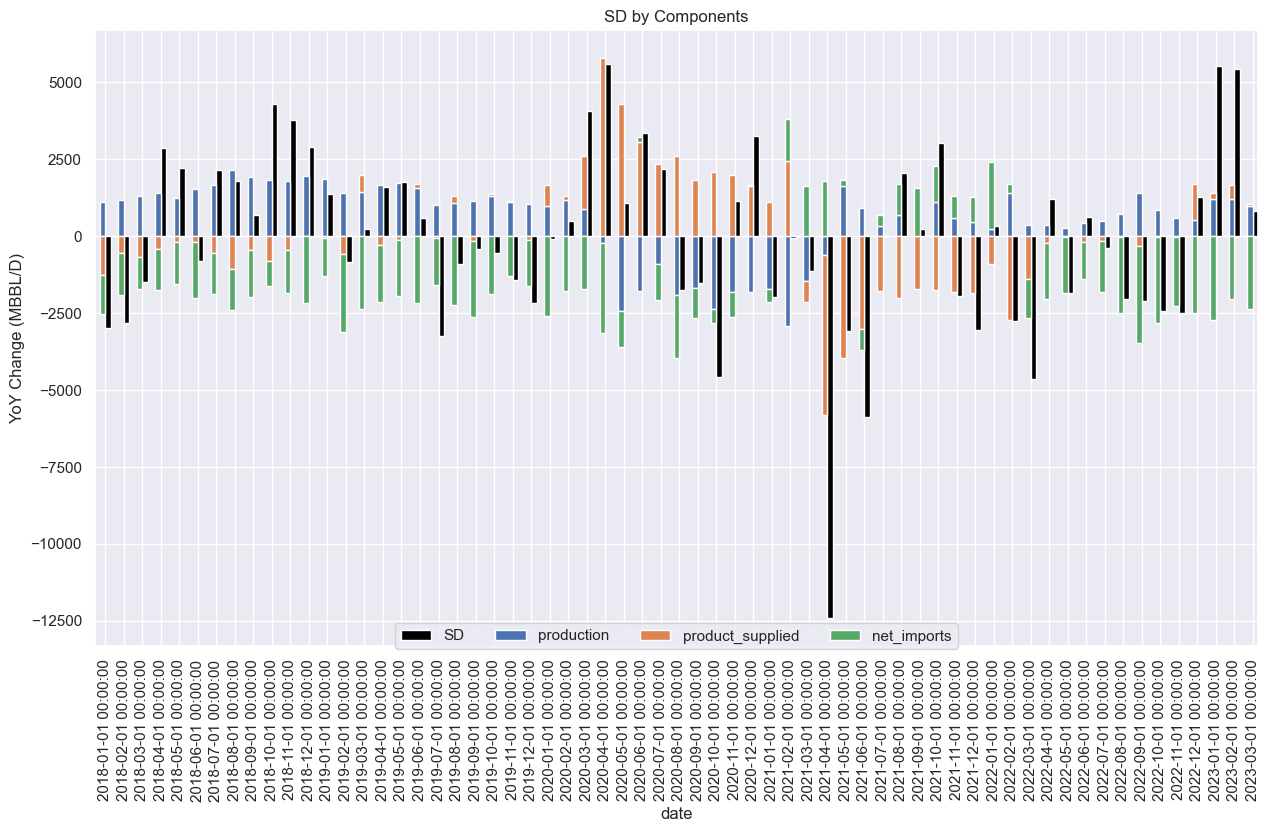

In [280]:
sd_data = sd[sd.index > '2017-12-01' ]
ax = sd_data.plot.bar(ylabel="MBBL", xlabel="Date", figsize=(15,8),
                 color='black', position=0, width=0.3)

changes.plot.bar(stacked=True, sharex=True, ax=ax, position=1, width=0.3)


plt.title('SD by Components')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
plt.ylabel('YoY Change (MBBL/D)')
plt.xlabel('date')
plt.show()

# weekly SD
SD balance = (weekly change - last year's weekly change) / 7
Factors = change in supply - change in consumption - change in net imports
positive SD balance = increasing in stocks
negative SD balance = decreasing in stocks

Factors:
-
- U.S. Refiner Net Input of Crude Oil (Thousand Barrels per Day) [x] (refinery_inputs)
- U.S. Net Imports of Crude Oil (Thousand Barrels per Day) [x] (net_imports)
- U.S. Field Production of Crude Oil (Thousand Barrels per Day) [x] (production)
- U.S. Product Supplied of Crude Oil and Petroleum Products (Thousand Barrels per Day) [x] (product_supplied)

SD:
- U.S. Ending Stocks of Crude Oil (Thousand Barrels) / 7 [x] (stocks)


In [281]:
stocks = oil.weekly_stocks(crude_only=True).to_frame() / 7
stocks['change'] = stocks['stocks'].diff(-1)
stocks['SD_change'] = stocks['change'].diff(-52)
stocks = stocks.sort_index()

In [282]:
product_supplied = oil.weekly_product_supplied()

In [283]:
imports, exports = oil.imports_exports(only_crude=True)
net_imports = imports - exports
net_imports = net_imports.rename("net_imports")

In [284]:
refinery_inputs = oil.weekly_refinery_inputs()

In [285]:
production = oil.weekly_field_production().sort_index()

In [286]:
master_df = pd.merge(product_supplied, net_imports, on='period')
master_df = pd.merge(master_df, refinery_inputs, on='period')
master_df = pd.merge(master_df, production, on='period')

In [287]:
change = master_df.diff(1) #changes compared to last week
changes = change.diff(52) #this weeks change compared to last year

In [288]:
sd_data = stocks['SD_change'].rename('SD')

In [289]:
start_date = '2022-01-01'
changes = changes[changes.index > start_date]
sd_data = sd_data[sd_data.index > start_date]

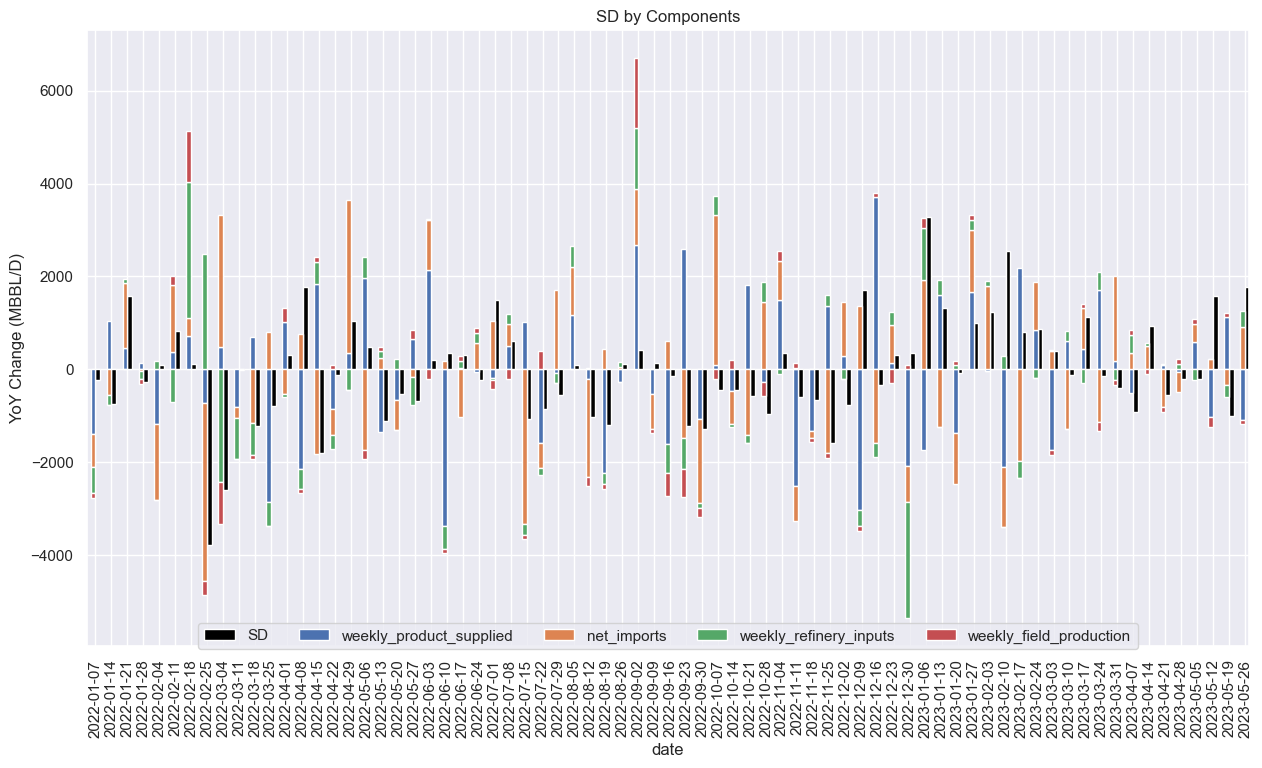

In [290]:
sd_data.index = pd.to_datetime(sd_data.index)

ax = sd_data.plot.bar(ylabel="MBBL", xlabel="Date", figsize=(15,8),
                 color='black', position=0, width=0.3)

changes.plot.bar(stacked=True, sharex=True, ax=ax, position=1, width=0.3)

ax.xaxis.set_major_formatter(plt.FixedFormatter(sd_data.index.strftime('%Y-%m-%d')))

plt.title('SD by Components')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
plt.ylabel('YoY Change (MBBL/D)')
plt.xlabel('date')
plt.show()

In [291]:
sd_data = sd_data.to_frame()
sd_data['year'] = sd_data.index.year

week_info = sd_data.index.isocalendar()
week_number = week_info['week']

sd_data = pd.merge(week_number, sd_data, left_index=True, right_index=True)

In [292]:
grouped = sd_data.groupby('year')

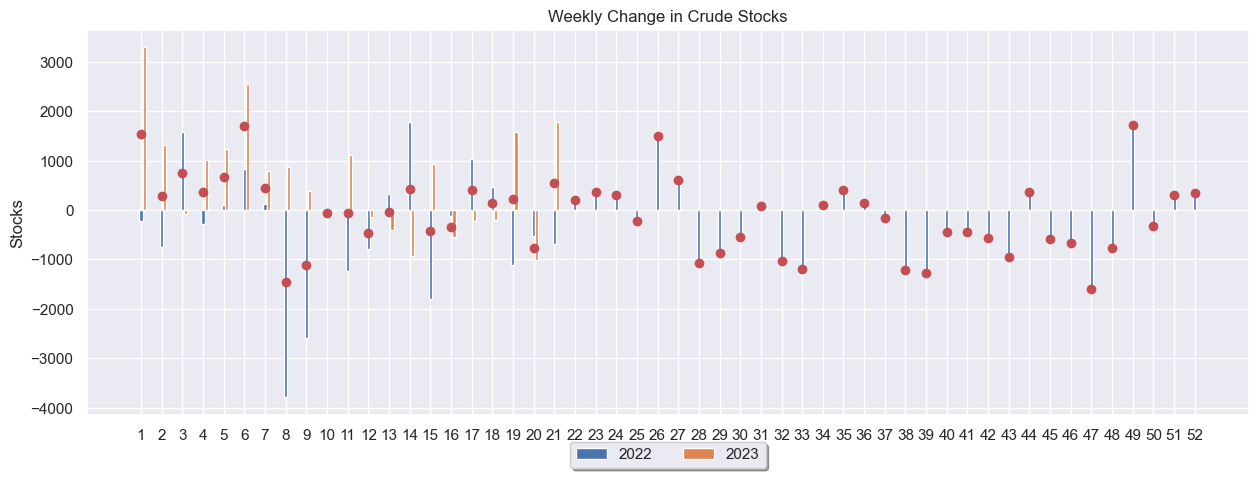

In [293]:
fig, ax = plt.subplots(figsize=(15,5))
i = 0
week_sum = {i:0 for i in range(1, 53)}
week_count = {i:0 for i in range(1, 53)}
for name, group in grouped:
    group = group[group['week'] < 53]
    weeks = group['week']
    data = group['SD']
    for w, d in zip(weeks, data):
        week_sum[w] += d
        week_count[w] += 1

    ax.bar(weeks + i * width, data, width=width, label=name)
    i += 1

means = []
for s, count in zip(week_sum.values(), week_count.values()):
    means.append(s/count)

means_df = pd.DataFrame(means)
plt.plot(means_df.index+1, means_df, 'ro')

plt.xticks(range(1, 53))
ax.set_ylabel('Stocks')
ax.set_xlabel('Week')
#move legend to bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Weekly Change in Crude Stocks')

plt.show()
